In [17]:
import sys
import os
import pandas as pd
import matplotlib
import pickle
import numpy as np
from matplotlib.ticker import FuncFormatter
from dataset.ipc2023_learning_domain_info import IPC2023_LEARNING_DOMAINS, get_test_ipc2023_learning_instance_files, get_best_bound, DIFFICULTIES, PROBLEM_INDICES
from itertools import product
from IPython.display import display, HTML
from util.scrape_log import scrape_search_log
from util.visualise import *

In [18]:
# _PAPER_DIR=str(Path.home())+"/papers/manuscripts/24-icaps-kernels"
_ICAPS_PAPER_DIR=str(Path.home())+"/papers/manuscripts/icaps-24-kernels"

In [19]:
pd.options.display.float_format = "{:.1f}".format

In [20]:
_DIFFICULTIES = ["easy", "medium", "hard"]
_MODELS = [
  "blind",
  "hff",
  # "lama-seq",
#   "lama-first",
  "muninn", 
  "goose", 
#   "ilg_1wl_1_0_linear-svr",
  "gI4max",
  "1wl",
  "2gwl",
  "2lwl"
  # "linear-regression",
#   "linear-svr", 
#   "quadratic-svr", 
#   "cubic-svr",
#   "rbf-svr", 
#   "ridge", 
#   "lasso", 
#   "mlp", 
]

WLS = {
    "1wl", "2gwl", "2lwl"
}
KERNELS = {"ridge", "lasso", "linear-svr", "quadratic-svr", "cubic-svr", "rbf-svr", "mlp"}
CLASSICAL = {"blind", "hff", "lama-first"}
GNNS = {"goose", "muninn", "gI4max"}

RENAME = {
    "ilg_1wl_1_0_linear-svr": "1wl_1"
}
def rename(model):
    if model in RENAME:
        return RENAME[model]
    return model

In [24]:
with open("ipc-2023-learning-reference-costs.pkl", 'rb') as file:
    REFERENCE_COSTS = {domain : [] for domain in IPC2023_LEARNING_DOMAINS}
    for (domain, diff_in_int, problem_index), reference_cost in pickle.load(file).items():
        REFERENCE_COSTS[domain].append(reference_cost)
# REFERENCE_COSTS  # (domain) -> [reference_cost] * 90

In [5]:
def get_data(domain):
    data = {}

    test_files = get_test_ipc2023_learning_instance_files()

    for model in _MODELS:
        d = {
            "solved": [],
            "expanded": [],
            "cost": [],
            "first_h": [],
            "quality": [],
            "c_opt": [],
            "difficulty": [],
            "time": [],
        }

        for difficulty in _DIFFICULTIES:
            for df, pf in test_files[domain]:
                if not difficulty in pf:
                    continue
                pf_name = os.path.basename(pf).replace(".pddl", "")
                stats = None

                if model=="muninn":
                    stats = {
                        "first_h": -1,
                        "solved": 0,
                        "time": -1,
                        "cost": -1,
                        "expanded": -1,
                        "evaluated": -1,
                    }

                    log_file = f"logs/muninn/{domain}_{difficulty}_{pf_name}.log"
                    plan_file = f"logs/muninn/{domain}_{difficulty}_{pf_name}.plan"
                    
                    if not os.path.exists(log_file):
                        continue
                    
                    cost = 0
                    if os.path.exists(plan_file):
                        with open(plan_file, "r") as f:
                            for line in f.readlines():
                                if len(line) > 0 and line[0] == "(":
                                    cost += 1

                    if cost > 0:
                        stats["solved"] = 1
                        stats["cost"] = cost
                        

                    """
                    [1] Subplan: 10, Heuristic: 9.998 -> goal, Expanded: 22, Generated: 86 (260 ms)
                    Writing file "plan.1" (10 actions)
                    Planned for 0 minutes and 0 seconds
                    """

                    for line in open(log_file, 'r').readlines():
                        if "[1]" in line and stats['solved'] == 0:
                            toks = line.replace(",", "").replace("(", "").split()
                            stats["first_h"] = float(toks[4])
                elif model == "gI4max":
                    log_file = f"icaps24_test_logs/{domain}_{difficulty}_{pf_name}_{domain}_ilg_L4_H64_mean_r0.log"
                elif model == "goose":
                    dd = {
                        "easy": "0",
                        "medium": "1",
                        "hard": "2",
                    }[difficulty]
                    log_file = f"logs/gnn_ipc2023_test/{domain}:p-{dd}-{pf_name.replace('p', '')}:goose_fd.log"
                    assert os.path.exists(log_file), log_file
                elif model in KERNELS:
                    log_file = f"logs/opt_ipc2023_test/{domain}_{difficulty}_{pf_name}_-scratch-sv11-dc6693-trained_models_kernel-opt_{model}_ig_{domain}_wl_1_0.joblib.log"
                    # assert os.path.exists(log_file), log_file
                elif model == "ilg_1wl_1_0_linear-svr":
                    log_file = f"icaps24_logs/{domain}_{difficulty}_{pf_name}_{domain}_{model}.log"
                elif model in WLS:
                    log_file = f"icaps24_test_logs/{domain}_{difficulty}_{pf_name}_ilg_{model}_linear-svr_H.log"
                else:
                    log_file = f"logs/ipc2023_{model}/{domain}_{difficulty}_{pf_name}_{model}.log"

                if stats is None:
                    if not os.path.exists(log_file):
                        continue
                    stats = scrape_search_log(log_file)

                for k in d:
                    if k in stats:
                        d[k].append(stats[k])

                c = stats["cost"] if stats["solved"] else -1
                c_opt = get_best_bound(domain, difficulty, pf_name)
                quality = c_opt / c
                quality = max(quality, 0)
                quality = min(quality, 1)
                d["quality"].append(quality)
                d["c_opt"].append(c_opt)
                d["difficulty"].append(difficulty)

        data[model] = d

    return data

In [6]:
def get_table_df(metric="quality"):
    d = {
        "domain": [],
    }
    for config in _MODELS:
        d[rename(config)] = []

    sum_scores = {config: 0 for config in _MODELS}

    for domain in IPC2023_LEARNING_DOMAINS:
        data = get_data(domain)
        d["domain"].append(domain)

        for config in _MODELS:
            score = sum(data[config][metric])
            d[rename(config)].append(score)
            sum_scores[config] += score

    d["domain"].append("sum")
    for config in _MODELS:
        d[rename(config)].append(sum_scores[config])

    return pd.DataFrame(d)

In [7]:
scores_df = get_table_df(metric="solved")
scores = scores_df.to_numpy()
scores = scores[:,1:]
display(scores_df)

,domain,blind,hff,muninn,goose,gI4max,1wl,2gwl,2lwl
0,blocksworld,8,28,40,29,53,13,18,20
1,childsnack,9,26,11,10,20,18,9,9
2,ferry,10,68,46,60,72,77,48,60
3,floortile,2,12,0,1,0,2,0,1
4,miconic,30,90,30,73,85,30,30,30
5,rovers,15,34,15,20,0,39,0,0
6,satellite,12,65,18,29,0,47,28,22
7,sokoban,27,36,26,30,0,38,0,29
8,spanner,30,30,32,30,0,30,30,30
9,transport,9,41,17,31,0,34,28,34


In [8]:
scores_df = get_table_df(metric="quality")
scores = scores_df.to_numpy()
scores = scores[:,1:]
display(scores_df)

,domain,blind,hff,muninn,goose,gI4max,1wl,2gwl,2lwl
0,blocksworld,8.0,14.1,40.0,23.9,48.2,8.7,11.6,9.1
1,childsnack,9.0,20.1,11.0,8.7,19.9,17.3,9.0,8.1
2,ferry,10.0,67.6,46.0,59.7,71.9,76.7,47.7,59.6
3,floortile,2.0,11.2,0.0,0.9,0.0,1.8,0.0,0.9
4,miconic,30.0,88.5,30.0,72.0,84.1,28.7,28.3,28.7
5,rovers,15.0,32.7,14.2,17.7,0.0,30.6,0.0,0.0
6,satellite,12.0,63.8,18.0,24.1,0.0,42.0,21.0,15.6
7,sokoban,27.0,26.3,24.3,26.7,0.0,34.9,0.0,26.5
8,spanner,30.0,30.0,32.0,29.6,0.0,25.9,26.4,30.0
9,transport,9.0,39.3,17.0,29.0,0.0,28.4,26.5,33.0


### Expanded 

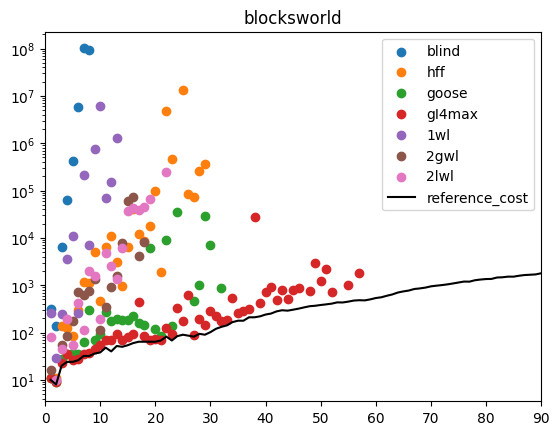

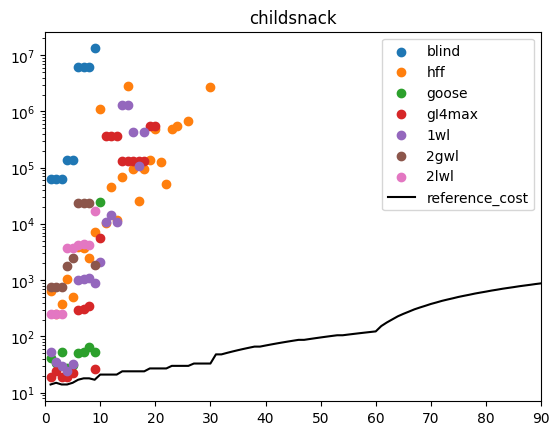

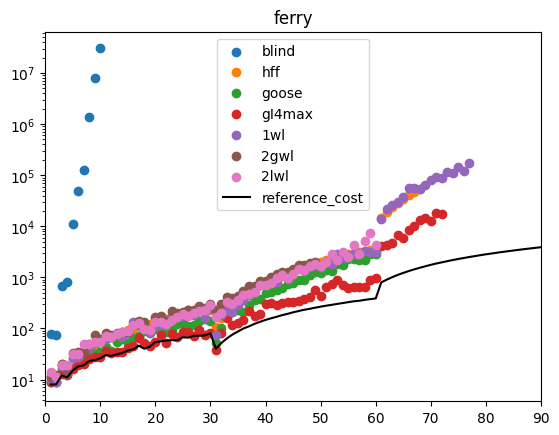

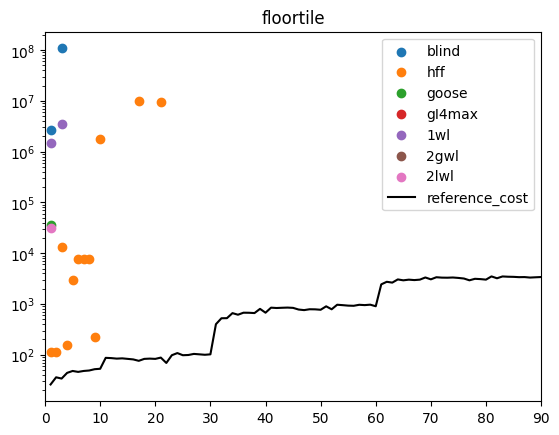

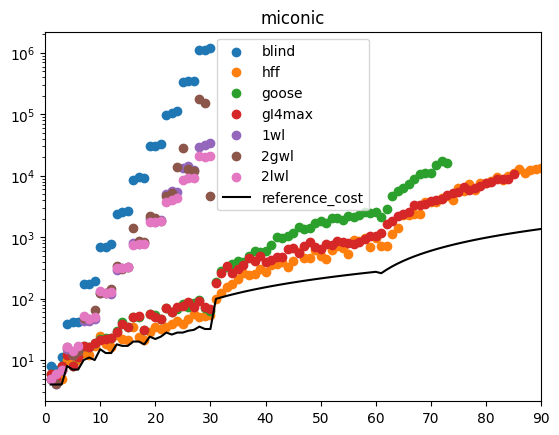

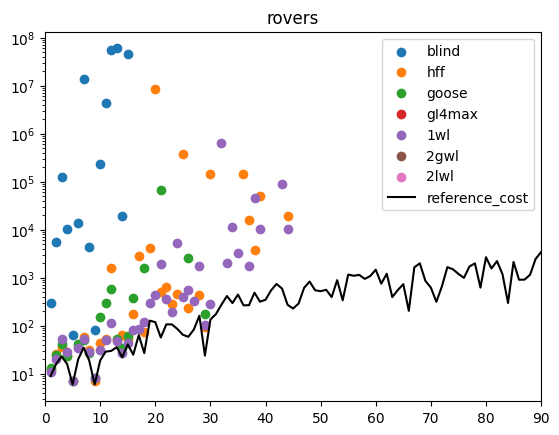

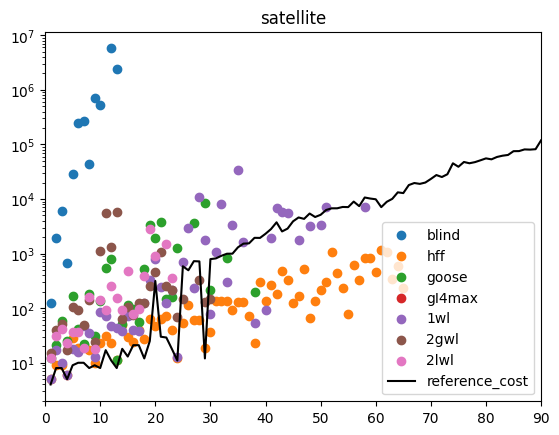

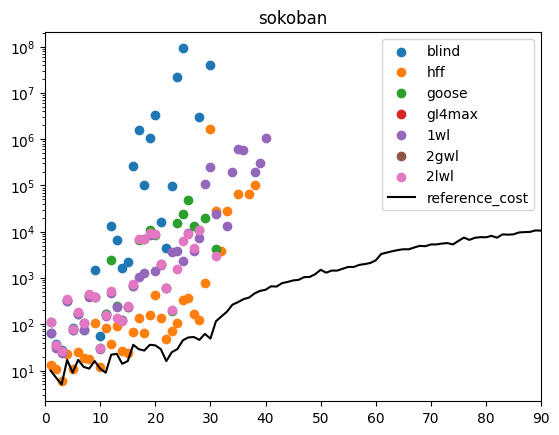

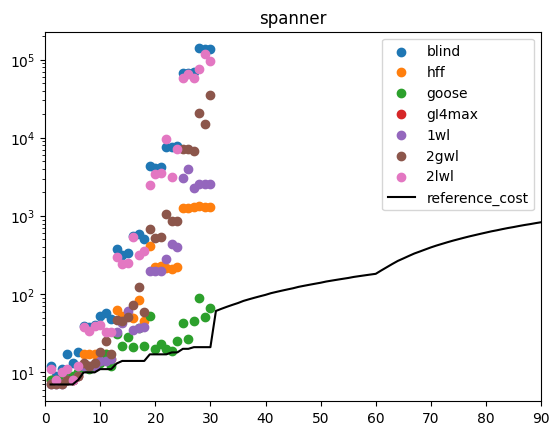

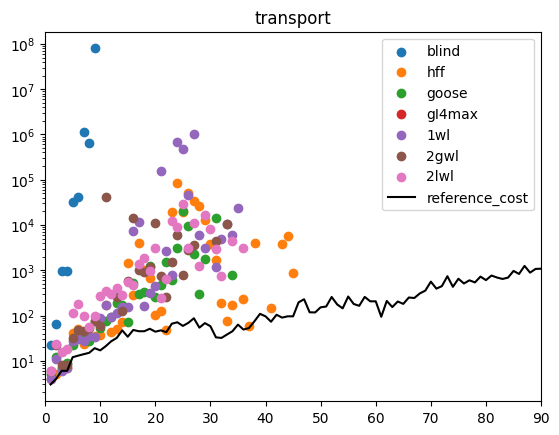

<Figure size 640x480 with 0 Axes>

In [25]:
EXPANDED_MODELS = ["blind", "hff", "goose", "gI4max", "1wl", "2gwl", "2lwl"]
for domain in IPC2023_LEARNING_DOMAINS:
    data = get_data(domain)
    for model in EXPANDED_MODELS:
        xs = []
        ys = []

        for i in range(90):
            if i >= len(data[model]["solved"]) or not data[model]["solved"][i]:
                continue
            xs.append(i+1)
            ys.append(data[model]["expanded"][i])

        plt.scatter(xs, ys, label=model)
    plt.plot(range(1, 91), REFERENCE_COSTS[domain], c='k', label="reference_cost")
    plt.title(domain)
    plt.xlim(0, 90)
    plt.yscale("log")
    plt.legend()
    plt.show()
    plt.clf()

In [10]:
def expanded_versus(Pair):
    Max_exp = 1e8
    plt.plot([1, Max_exp], [1, Max_exp], c='k', alpha=0.5, linestyle='dashed')
    for domain in IPC2023_LEARNING_DOMAINS:
        exp = {model:[] for model in Pair}
        data = get_data(domain)
        for i in range(90):
            for model in Pair:
                if i >= len(data[model]["solved"]) or not data[model]["solved"][i]:
                    expanded = Max_exp
                else:
                    expanded = data[model]["expanded"][i]
                exp[model].append(expanded)
        plt.scatter(exp[Pair[0]], exp[Pair[1]], label=domain, alpha=0.7)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel(Pair[0])
    plt.ylabel(Pair[1])
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.show()

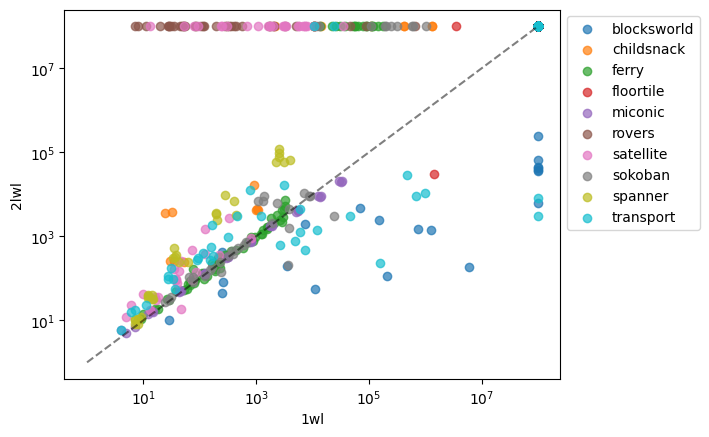

In [11]:
""" 2lwl vs 1wl """
expanded_versus(["1wl", "2lwl"])

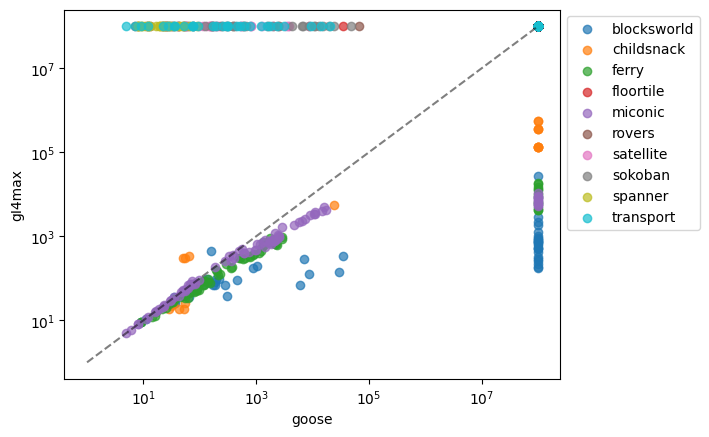

In [12]:
""" AAAI24-goose vs gI4max """
expanded_versus(["goose", "gI4max"])

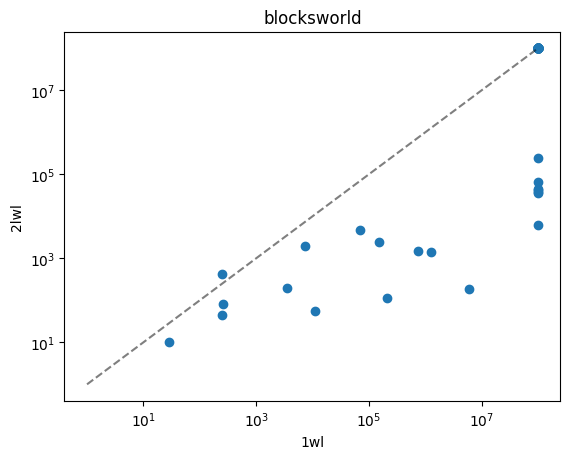

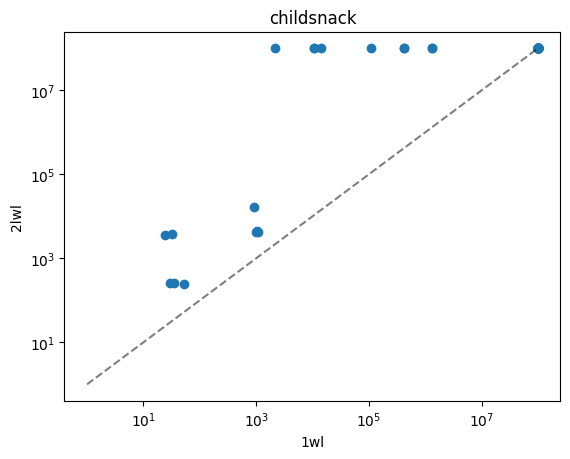

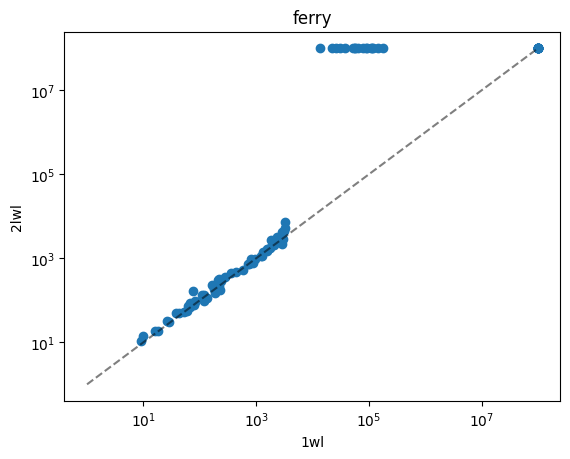

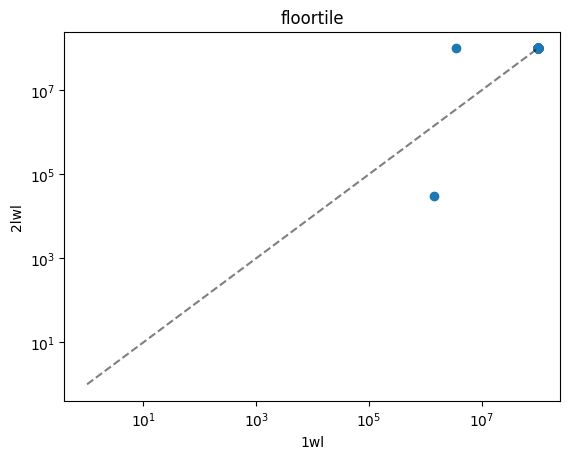

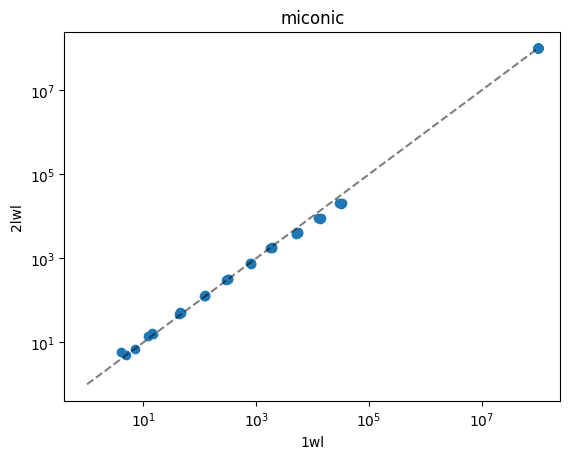

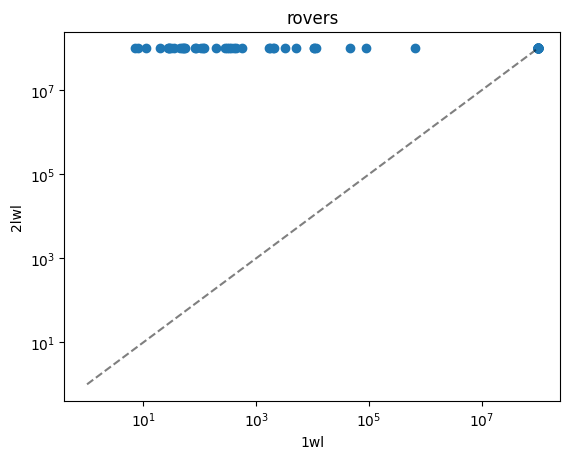

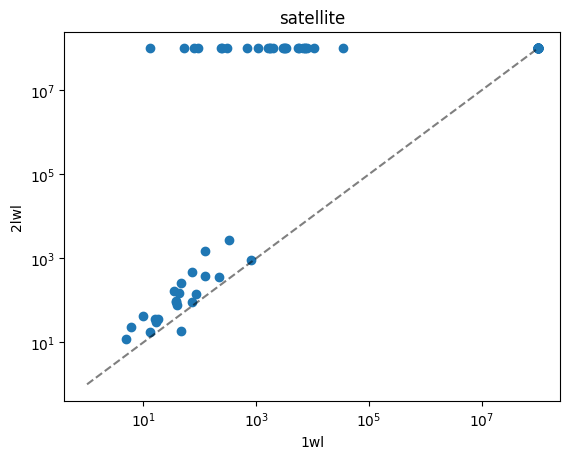

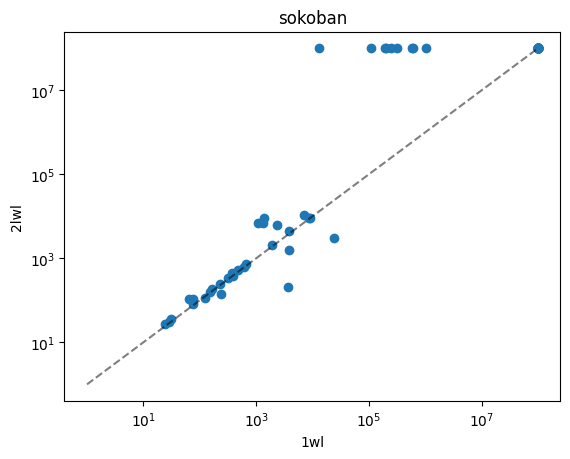

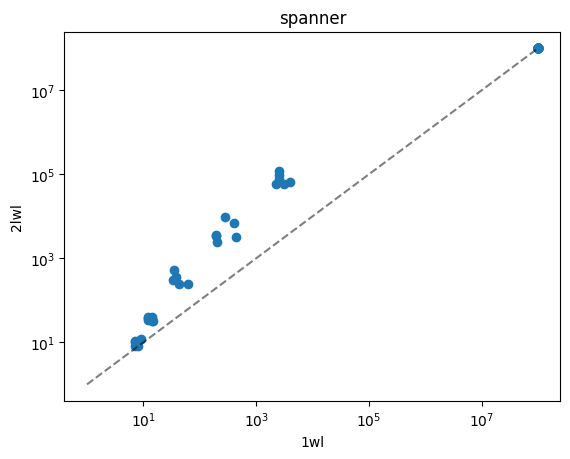

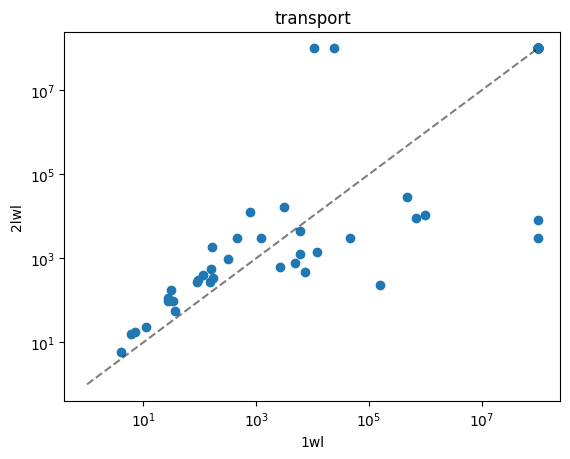

<Figure size 640x480 with 0 Axes>

In [13]:
""" 2lwl vs 1wl per domain version """
Pair = ["1wl", "2lwl"]
Max_exp = 1e8
for domain in IPC2023_LEARNING_DOMAINS:
    plt.plot([1, Max_exp], [1, Max_exp], c='k', alpha=0.5, linestyle='dashed')
    exp = {model:[] for model in Pair}
    data = get_data(domain)
    for i in range(90):
        for model in Pair:
            if i >= len(data[model]["solved"]) or not data[model]["solved"][i]:
                expanded = Max_exp
            else:
                expanded = data[model]["expanded"][i]
            exp[model].append(expanded)
    plt.scatter(exp[Pair[0]], exp[Pair[1]])
    plt.xscale("log")
    plt.yscale("log")
    plt.title(domain)
    plt.xlabel(Pair[0])
    plt.ylabel(Pair[1])
    plt.show()
    plt.clf()

### More refined data

In [14]:
def get_metrics_df(data):
  d = {
    "config": [],
    "quality": [],
    "solved": [],
    "tried": [],
    "e_quality": [],
    "e_solved": [],
    "e_tried": [],
    "m_quality": [],
    "m_solved": [],
    "m_tried": [],
    "h_quality": [],
    "h_solved": [],
    "h_tried": [],
  }
  for config in _MODELS:
    d["config"].append(config)
    d["quality"].append(sum(data[config]["quality"]))
    d["solved"].append(sum(data[config]["solved"]))
    d["tried"].append(len(data[config]["solved"]))
    for difficulty in _DIFFICULTIES:
      quality = 0
      solved = 0
      tried = 0
      for i, prob_solved in enumerate(data[config]["solved"]):
        if data[config]["difficulty"][i] == difficulty:
          quality += data[config]["quality"][i]
          solved += prob_solved
          tried += 1
      d[f"{difficulty[0]}_quality"].append(quality)
      d[f"{difficulty[0]}_solved"].append(solved)
      d[f"{difficulty[0]}_tried"].append(tried)
  return pd.DataFrame(d)

In [15]:
df = get_metrics_df(get_data("satellite"))
df

,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,blind,12.0,12,90,12.0,12,30,0,0,30,0,0,30
1,hff,63.8,65,90,28.8,30,30,30,30,30,5,5,30
2,muninn,18.0,18,90,16.0,16,30,2,2,30,0,0,30
3,goose,24.1,29,90,22.1,27,30,2,2,30,0,0,30
4,gI4max,0.0,0,0,0.0,0,0,0,0,0,0,0,0
5,1wl,42.0,47,60,25.0,30,30,17,17,30,0,0,0
6,2gwl,21.0,28,60,21.0,28,30,0,0,30,0,0,0
7,2lwl,15.6,22,60,15.6,22,30,0,0,30,0,0,0


### To latex table

In [16]:
""" coverage_tall.tex """
nnn = 0

scores_df = get_table_df()
scores = scores_df.to_numpy()
scores = scores[:,1:]

# ret  = r"\begin{tabular}{ c " + " ".join(["c" for _ in range(4*len(_MODELS))]) + r"} \toprule Domain "
ret  = r"\begin{tabular}{" + "c " + " ".join(["p{\coveragewidth}" for _ in range(len(_MODELS))]) + r"} \toprule Domain "

for model in _MODELS:
    ret += f"& \\header{{\{model.replace('-', '')}}} "
ret += r"\\ \midrule" + '\n'

all_solved = {
  "easy": np.zeros(len(_MODELS)).astype(int),
  "medium": np.zeros(len(_MODELS)).astype(int),
  "hard": np.zeros(len(_MODELS)).astype(int),
  "all": np.zeros(len(_MODELS)).astype(int),
}
all_quality = {
  "easy": np.zeros(len(_MODELS)),
  "medium": np.zeros(len(_MODELS)),
  "hard": np.zeros(len(_MODELS)),
  "all": np.zeros(len(_MODELS)),
}

for domain in IPC2023_LEARNING_DOMAINS:
    ret += f"\\multirow{{4}}{{*}}{{{domain}}}"
    data = (get_metrics_df(get_data(domain)).to_numpy())

    # coverage then cost
    solved = {
        "easy": data[:,5].T,
        "medium": data[:,8].T,
        "hard": data[:,11].T,
        "all": data[:,2].T,
    }

    for difficulty in ["easy", "medium", "hard", "all"]:
        scores_domain = solved[difficulty]
        sorted_scores_domain = sorted(scores_domain, reverse=True)
        all_solved[difficulty] += np.array(scores_domain).astype(int)
        for i in range(len(solved["easy"])):
            chunks = []
            best_score = max(scores_domain)
            score = solved[difficulty][i]
            if score == 0:
                chunks.append("-")
            elif score==sorted_scores_domain[0]:
                chunks.append(f"\\first{{{score}}}")
            elif score==sorted_scores_domain[1]:
                chunks.append(f"\\second{{{score}}}")
            elif score==sorted_scores_domain[2]:
                chunks.append(f"\\third{{{score}}}")
            else:
                chunks.append(f"{score}")

            chunk = " & ".join(chunks)
            ret += f" & {chunk}"

        if difficulty != "all":
            ret += "\\\\ \n"

    if domain==IPC2023_LEARNING_DOMAINS[-1]:
        ret += "\\\\ \midrule \n"
    else:
        ret += "\\\\ \cmidrule(lr){2-" + str(len(_MODELS)+1) + "} \n"

ret += f"\\multirow{{4}}{{*}}{{sum}}"

for difficulty in ["easy", "medium", "hard", "all"]:
    for i in range(len(all_solved["easy"])):
        chunks = []

        scores_domain = all_solved[difficulty]

        sorted_scores_domain = sorted(scores_domain, reverse=True)
        sorted_scores_domain = [round(x, 1) for x in sorted_scores_domain]
        best_score = max(scores_domain)
        score = all_solved[difficulty][i]
        if score == 0:
            chunks.append("-")
        elif score==sorted_scores_domain[0]:
            chunks.append(f"\\first{{{score}}}")
        elif score==sorted_scores_domain[1]:
            chunks.append(f"\\second{{{score}}}")
        elif score==sorted_scores_domain[2]:
            chunks.append(f"\\third{{{score}}}")
        else:
            chunks.append(f"{score}")

        chunk = " & ".join(chunks)
        ret += f" & {chunk}"

    if difficulty != "all":
        ret += "\\\\ \n"

ret += r" \\ \bottomrule\end{tabular}"

for dir in [_ICAPS_PAPER_DIR]:
    f = open(f"{dir}/figures/coverage_tall.tex", 'w')
    f = open(f"{dir}/figures/coverage_tall.tex", 'w')
    f.write(ret)
    f.close()